In [1]:
import os
import torch
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from transformers import LongformerTokenizer, LongformerModel, AutoTokenizer, AutoModel
from pycaret.classification import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
# Get the root directory of the project (assuming the notebook is inside "notebook/")
notebook_dir = os.getcwd()  # Gets the current working directory
project_root = os.path.abspath(os.path.join(notebook_dir, ".."))  # Moves one level up
project_root

'C:\\Users\\jeiso\\Documents\\Maestria\\Semestre #1\\Reto\\MentalRiskES-2025'

In [3]:
path_dataset = os.path.join(project_root, "notebook", "dataset_tasks.xlsx")
dataset = pd.read_excel(path_dataset)
dataset['message'] = dataset['message'].fillna("").astype(str)
dataset.head()

,message,label_text,level,label
0,el canal del amigo se llama loco por el tradin...,trading,0,1
1,ganancia e ganancia chico [SEP] si lo conseguí...,trading,0,1
2,fijate cuanto e el margen en negativo y le agr...,trading,1,1
3,alguna entradita .. ? [SEP] spot está funciona...,trading,0,1
4,voy cargando la escopeta pa longuear alguna mo...,trading,1,1


# TASK 2: MULTI CLASSIFICATION

In [4]:
x_task2 = dataset['message']
y_task2 = dataset['label']

In [5]:
# load model and tokenizer

# Longformer
model_name = "PlanTL-GOB-ES/longformer-base-4096-bne-es"
tokenizer = LongformerTokenizer.from_pretrained(model_name)
model = LongformerModel.from_pretrained(model_name).to(device)

# BETO
# model_name = "dccuchile/bert-base-spanish-wwm-cased"
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# model = AutoModel.from_pretrained(model_name).to(device)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'LongformerTokenizer'.
Some weights of LongformerModel were not initialized from the model checkpoint at PlanTL-GOB-ES/longformer-base-4096-bne-es and are newly initialized: ['longformer.pooler.dense.bias', 'longformer.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [6]:
def get_longformer_embedding(text):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=4096
    )
    # Mover los tensores de entrada a GPU
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    # Convertir los resultados a CPU para trabajar con numpy
    return outputs.last_hidden_state.mean(dim=1).squeeze().cpu().numpy()

# Aplicamos la función a todos los mensajes
x_task2_embeddings = np.array([get_longformer_embedding(text) for text in x_task2])

In [7]:
x_task2_embeddings

array([[-0.01389358, -0.20139731, -0.13571012, ...,  0.15468991,
        -0.3734635 ,  0.13759978],
       [-0.02577653, -0.18896374, -0.08829255, ...,  0.12269702,
        -0.3488162 ,  0.12038291],
       [-0.03637802, -0.19033602, -0.06889474, ...,  0.11036424,
        -0.3143504 ,  0.11575615],
       ...,
       [ 0.02749947, -0.2446506 , -0.23755276, ...,  0.19614716,
        -0.41240108,  0.16012979],
       [ 0.02731508, -0.24558362, -0.23764598, ...,  0.19622123,
        -0.4123838 ,  0.15980375],
       [ 0.02829135, -0.24712177, -0.23836268, ...,  0.19791567,
        -0.41369712,  0.16134548]], dtype=float32)

In [8]:
print('**Sample train:', sorted(Counter(y_task2).items()))

**Sample train: [(0, 85), (1, 135), (2, 85), (3, 104)]


In [9]:
# We create an instance of RandomOverSampler to balance the classes.
# - random_state=10000: A seed is set for reproducibility.

ros_task2 = RandomOverSampler(random_state=10000)

# We apply oversampling to generate new instances of the minority classes to equal the amount of the majority class.
x_task2, y_task2 = ros_task2.fit_resample(x_task2_embeddings, y_task2)

# We show the distribution of classes after oversampling.
print('**OverSample train:', sorted(Counter(y_task2).items()))

**OverSample train: [(0, 135), (1, 135), (2, 135), (3, 135)]


In [10]:
x_task2

array([[-0.01389358, -0.20139731, -0.13571012, ...,  0.15468991,
        -0.3734635 ,  0.13759978],
       [-0.02577653, -0.18896374, -0.08829255, ...,  0.12269702,
        -0.3488162 ,  0.12038291],
       [-0.03637802, -0.19033602, -0.06889474, ...,  0.11036424,
        -0.3143504 ,  0.11575615],
       ...,
       [ 0.00207365, -0.21852641, -0.17248565, ...,  0.16326605,
        -0.37076032,  0.1395567 ],
       [ 0.01279789, -0.23679578, -0.20403495, ...,  0.18715647,
        -0.3967473 ,  0.15074924],
       [ 0.00780323, -0.22728433, -0.19990763, ...,  0.17739746,
        -0.39207745,  0.15115176]], dtype=float32)

In [11]:
setup_task2 = setup(
    data=x_task2, # Input data set (feature matrix)
    target=y_task2, # Target variable (classification labels)
    session_id=123, # Random seed to ensure reproducibility
    train_size=0.8, # Percentage of data used for training (80%)
    log_experiment=True, # Enable experiment logging (mlflow)
    experiment_name='Mentalrisk_task2' # Name of experiment for tracking (mlflow)
)

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Multiclass
3,Original data shape,"(540, 769)"
4,Transformed data shape,"(540, 769)"
5,Transformed train set shape,"(432, 769)"
6,Transformed test set shape,"(108, 769)"
7,Numeric features,768
8,Preprocess,True
9,Imputation type,simple


In [12]:
# We compared multiple classification models using cross-validation with 10 folds.
model_task2 = compare_models(fold=10)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:22:04
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9930,0.9996,0.9930,0.9936,0.9930,0.9907,0.9909,0.0500
et,Extra Trees Classifier,0.9907,0.9997,0.9907,0.9921,0.9909,0.9876,0.9880,0.0390
lr,Logistic Regression,0.9884,0.0000,0.9884,0.9897,0.9885,0.9846,0.9850,0.2720
gbc,Gradient Boosting Classifier,0.9884,0.0000,0.9884,0.9894,0.9884,0.9846,0.9849,2.7390
lightgbm,Light Gradient Boosting Machine,0.9861,0.9991,0.9861,0.9876,0.9858,0.9815,0.9821,0.5330
dt,Decision Tree Classifier,0.9814,0.9875,0.9814,0.9822,0.9813,0.9753,0.9756,0.0250
knn,K Neighbors Classifier,0.9628,0.9964,0.9628,0.9672,0.9624,0.9504,0.9521,0.1940
ridge,Ridge Classifier,0.9536,0.0000,0.9536,0.9617,0.9531,0.9382,0.9412,0.0180
nb,Naive Bayes,0.8540,0.9561,0.8540,0.8603,0.8534,0.8052,0.8079,0.0190
svm,SVM - Linear Kernel,0.8353,0.0000,0.8353,0.8345,0.8093,0.7804,0.8098,0.0220


2025/03/22 22:22:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/22 22:22:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/22 22:22:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/22 22:22:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/22 22:22:52 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/22 22:22:52 

In [13]:
# We create a classification model.
best_model = create_model('rf')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:23:16
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
2,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
3,0.9767,1.0000,0.9767,0.9787,0.9766,0.9690,0.9697
4,0.9767,1.0000,0.9767,0.9787,0.9767,0.9690,0.9697
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
7,0.9767,0.9960,0.9767,0.9787,0.9767,0.9690,0.9697
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


2025/03/22 22:23:17 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [14]:
print(best_model)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


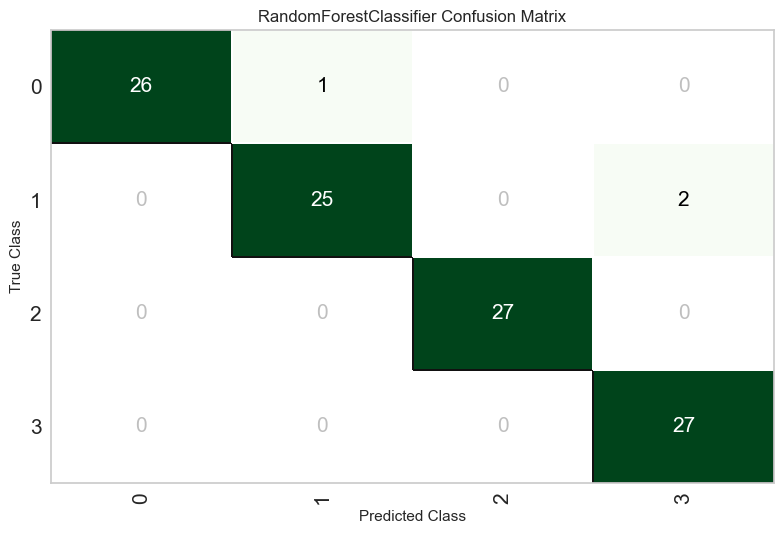

In [15]:
plot_model(best_model, plot='confusion_matrix')

In [16]:
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [17]:
save_model(best_model, 'rf_task2')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['feature_1', 'feature_2',
                                              'feature_3', 'feature_4',
                                              'feature_5', 'feature_6',
                                              'feature_7', 'feature_8',
                                              'feature_9', 'feature_10',
                                              'feature_11', 'feature_12',
                                              'feature_13', 'feature_14',
                                              'feature_15', 'feature_16',
                                              'feature_17', 'feature_18',
                                              'feature_19', 'feat...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='g